<a href="https://colab.research.google.com/github/HilbertN/Redes_Neuronales/blob/main/RN20_Pron%C3%B3sticoTempTarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import numpy as np

Obtenemos los datos y descomprimimos

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-02 23:42:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.138.213, 54.231.230.96, 52.217.90.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.138.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  56.6MB/s    in 0.2s    

2023-11-02 23:42:27 (56.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


# Preparación de los datos

Imprimimos los encabezados y separamos los datos del encabezado

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
#Esto es útil para dividir un bloque de texto en líneas individuales,
# lo que es comúnmente necesario cuando se trabaja con datos de texto, como un archivo CSV o un archivo de registro.
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Separamos datos de temperatura y los demás

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [8]:
raw_data[0,:]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

Graficamos la serie de tiempo de temperaturas

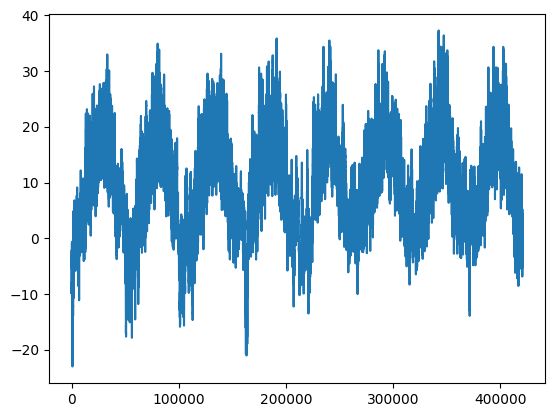

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Los datos son tomados cada 10 minutos. Tienen mucha resolución!!. Por ejemplo, podemos graficar los primeros diez días. 24x6=144 <- Es el número de datos correspondiente a un día.

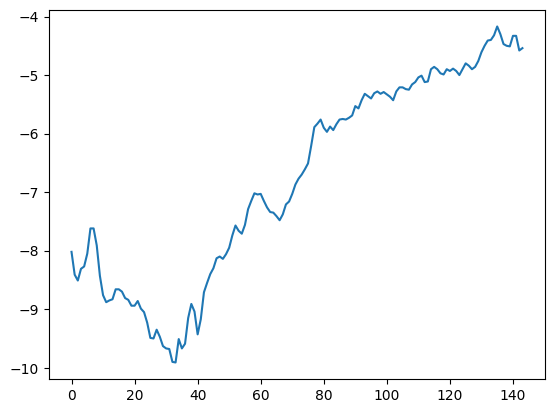

In [6]:
plt.plot(range(144), temperature[:144])



1.   Genera secuencias x para entrenamiento (50%), validación (25%) y prueba (25%) de 120 elementos de longitud a partir de los datos de temperatura.
Aquí hay un ejemplo de una forma de lograrlo para generar un conjunto de secuencias:



Calculamos los tamaños de muestra para datos de entrenamiento, validación y prueba.

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


La formulación exacta del problema será la siguiente: dada una serie de datos que cubre los últimos cinco días y se muestrea una vez por hora, ¿podemos predecir la temperatura en 24 horas?

Primero, vamos a preprocesar los datos a un formato que una red neuronal pueda procesar. Esto es fácil: los datos ya son numéricos, por lo que no necesitas hacer ninguna vectorización. Sin embargo, cada serie temporal en los datos está en una escala diferente (por ejemplo, la presión atmosférica, medida en mbar, está alrededor de 1,000, mientras que H2OC, medida en milimoles por mol, está alrededor de 3). Normalizaremos cada serie temporal de manera independiente para que todas tengan valores pequeños en una escala similar. Utilizaremos los primeros 210,225 pasos de tiempo como datos de entrenamiento, por lo que calcularemos la media y la desviación estándar solo en esta fracción de los datos.

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
n=np.array([[1,2,3],[3,4,8],[2,6,7]])
n

array([[1, 2, 3],
       [3, 4, 8],
       [2, 6, 7]])

In [11]:
n[:2]

array([[1, 2, 3],
       [3, 4, 8]])

In [12]:
n[:2].mean(axis=0)

array([2. , 3. , 5.5])

A continuación, creemos un objeto de conjunto de datos (Dataset) que genere lotes de datos de los últimos cinco días junto con la temperatura objetivo 24 horas en el futuro. Dado que las muestras en el conjunto de datos son altamente redundantes (la muestra N y la muestra N + 1 tendrán la mayoría de sus pasos de tiempo en común), sería un desperdicio de memoria asignar explícitamente memoria para cada muestra. En su lugar, generaremos las muestras sobre la marcha mientras mantenemos en memoria solo los arreglos originales de raw_data y temperatura, y nada más.

Podríamos escribir fácilmente un generador en Python para hacer esto, pero Keras tiene una utilidad de conjunto de datos incorporada que hace justamente eso (timeseries_dataset_from_array()), por lo que podemos ahorrarnos algo de trabajo utilizando esta función. Por lo general, puedes usarla para cualquier tipo de tarea de pronóstico de series temporales.

In [24]:

int_sequence = np.arange(10) #Generamos un array de enteros del 0 al 9
dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],    #secuencia para valores de x
    targets = int_sequence[3:], #secuencia para extraer los valores y
    sequence_length=3, #tamano de las secuencias x
    batch_size=2,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)


for inputs, targets in dataset:
  print("series x")
  print(inputs)
  print("y")
  print(targets)

series x
tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64)
y
tf.Tensor([3 4], shape=(2,), dtype=int64)
series x
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64)
y
tf.Tensor([5 6], shape=(2,), dtype=int64)
series x
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
y
tf.Tensor([7], shape=(1,), dtype=int64)


In [17]:
inputs.shape

TensorShape([1, 3])

O bien, si queremos visualizar de forma mas ordenada

In [14]:
for inputs, targets in dataset:
   for i in range(inputs.shape[0]):
     print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Utilizaremos timeseries_dataset_from_array() para crear tres conjuntos de datos: uno para entrenamiento, otro para validación y uno más para pruebas.

Utilizaremos los siguientes valores de parámetros:

    sampling_rate = 6: Las observaciones se muestrearán a una tasa de un punto de datos por hora, es decir, conservaremos un punto de datos de cada 6.

    sequence_length = 120: Las observaciones abarcarán un período de 5 días (120 horas). Cada secuencia contendrá 120 puntos de datos.

    delay = sampling_rate * (sequence_length + 24 - 1): Esto se utiliza para determinar el objetivo de cada secuencia. El objetivo será la temperatura 24 horas después del final de la secuencia. El valor de delay se calcula en función de la tasa de muestreo y la longitud de la secuencia.

Al crear el conjunto de datos de entrenamiento, pasaremos start_index = 0 y end_index = num_train_samples para utilizar solo el primer 50% de los datos. Para el conjunto de validación, pasaremos start_index = num_train_samples y end_index = num_train_samples + num_val_samples para utilizar el siguiente 25% de los datos. Finalmente, para el conjunto de pruebas, pasaremos start_index = num_train_samples + num_val_samples para utilizar las muestras restantes.

In [18]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
     raw_data[:-delay],
     targets=temperature[delay:],
     sampling_rate=sampling_rate,
     sequence_length=sequence_length,
     shuffle=True,
     batch_size=batch_size,
     start_index=0,
     end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay], targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [22]:
n[1:]

array([[3, 4, 8],
       [2, 6, 7]])

In [21]:
n[:-1]

array([[1, 2, 3],
       [3, 4, 8]])

El reto en el código de arriba es simplemente calcular los valores de start_index y end_idex para obtener el número de secuencias x desadas.

# Probando modelos

# Conv 1D